In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import Lasso, LogisticRegression
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import demoji
import pandas_dedupe
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
demoji.download_codes()
nltk.download('stopwords')

... OK (Got response in 1.26 seconds)
Writing emoji data to C:\Users\USER\.demoji\codes.json ...
... OK


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import Data and Perform Initial Analysis
***

In [2]:
df = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.shape

(129971, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [6]:
def df_detail(df):
    temp = pd.DataFrame(df.dtypes, columns=['dtypes'])
    temp = temp.reset_index()
    temp['Col_Name'] = temp['index']
    temp = temp[['Col_Name','dtypes']]
    temp['Missing_value'] = df.isnull().sum().values
    temp['Missing_rate (%)'] = df.isnull().sum().values / df.shape[0] * 100
    temp['Unique_value'] = df.nunique().values
    temp['Unique_rate (%)'] = df.nunique().values / df.shape[0] * 100
    return temp

In [7]:
df_detail(df)

,Col_Name,dtypes,Missing_value,Missing_rate (%),Unique_value,Unique_rate (%)
0,country,object,63,0.048472,43,0.033084
1,description,object,0,0.000000,119955,92.293666
2,designation,object,37465,28.825661,37979,29.221134
3,points,int64,0,0.000000,21,0.016157
4,price,float64,8996,6.921544,390,0.300067
5,province,object,63,0.048472,425,0.326996
6,region_1,object,21247,16.347493,1229,0.945596
7,region_2,object,79460,61.136715,17,0.013080
8,taster_name,object,26244,20.192197,19,0.014619
9,taster_twitter_handle,object,31213,24.015357,15,0.011541


The columns with relatively high missing value rate are region_2, region_1, taster_name, designation, and twitter_handle.


## Analyzing Features
---

### Numerical features
 - Points (int64)
 - Price (float64)

In [8]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


#### Points
---

The value of points are distributed between 80 and 100, let's take a look at the distribution by plotting a histogram.

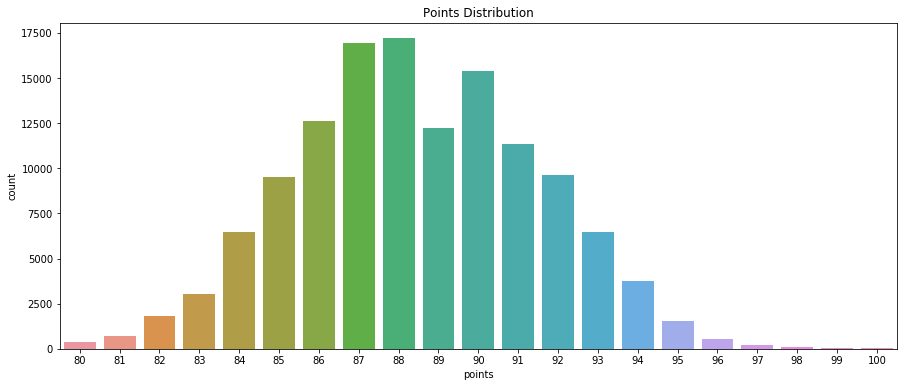

In [9]:
tmp_df = pd.DataFrame({'points': df["points"].value_counts().index, 'count': df["points"].value_counts().values})
plt.figure(figsize = (15,6))
plt.title('Points Distribution')
sns.barplot(x= 'points', y= 'count', data=tmp_df)
locs, labels = plt.xticks()
plt.show()

Base on the plot, there are no outliers and null in this column, so we won't do any cleaning for points.

#### Price
---

- We're worried about wines with missing value in "Price" column since we want to discover the price-performace ratio of different wine types, and we don't want to make prediction for wines which price is missing.
- Drop all the rows which "price" value is NaN.

In [10]:
df = df.dropna(subset=['price'])
df = df.reset_index(drop=True)

The mininum price is 4, the maximum price is 3,300, and the mean value is 35.36. Based on the min, max, and mean, we can know that the distribution of price is not an normal distribution, it might contains some outliers, so we would like to look at the distribution of price by plotting a histogram too.


We're curious about how many wine records which price is more than 1,000. We found that 14 wine's price is greater than 1,000 and 12 of them are from France. France produce some high-level or noble wines and this can interpret that there are some extremely high price wines in France.

In [11]:
df[(df['price'] > 1000)]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1472,France,"A massive wine for Margaux, packed with tannin...",NaN,98,1900.0,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux
1480,France,"Such a generous and ripe wine, with a dark cor...",NaN,97,1100.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château La Mission Haut-Brion 2009 Pessac-Léo...,Bordeaux-style Red Blend,Château La Mission Haut-Brion
1485,France,"Solid, very structured, packed with dense and ...",NaN,96,1200.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château Haut-Brion 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Haut-Brion
1488,France,"The purest Cabernet Sauvignon fruit, with dark...",NaN,96,1300.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild
14744,France,The wine is a velvet glove in an iron fist. Th...,NaN,96,2500.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus
60684,France,This extravagantly perfumed wine has great jui...,NaN,97,2000.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus
74674,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet
83255,Austria,"Wet earth, rain-wet stones, damp moss, wild sa...",Ried Loibenberg Smaragd,94,1100.0,Wachau,NaN,NaN,Anne Krebiehl MW,@AnneInVino,Emmerich Knoll 2013 Ried Loibenberg Smaragd Gr...,Grüner Veltliner,Emmerich Knoll
91549,France,"A superb wine from a great year, this is power...",NaN,96,2500.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair
103975,France,"Almost black in color, this stunning wine is g...",NaN,100,1500.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild


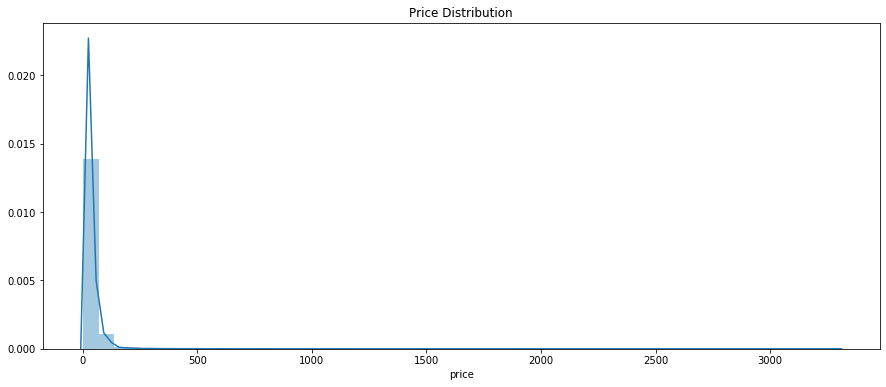

In [12]:
plt.figure(figsize=(15,6))
plt.title("Price Distribution")
ax = sns.distplot(df["price"])

By looking at the histogram, we found that the distribution of price is right skewed. If we want to have a better distribution of price, we'll need to drop the tail or make some transformation to bring it closer to a normal distribution. There are two options that we want to try:
1. Drop the tail: Drop values that greater than 100 dollars. 
2. Use the log transformation: We'll take log(1+x) to avoid running into issues with zero counts.

#### Drop the tail
---

2.7823930564166153 % of price is greater then 100 USD


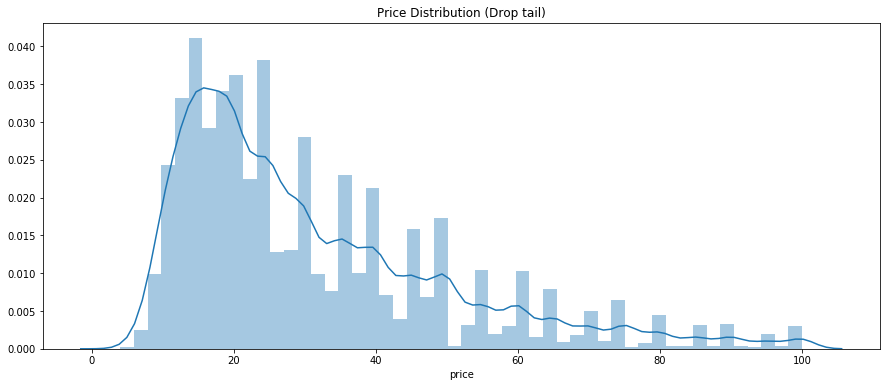

In [13]:
plt.figure(figsize=(15,6))
plt.title("Price Distribution (Drop tail)")
ax = sns.distplot(df[df["price"]<=100]['price'])
per = df[df['price']>100].shape[0]/df.shape[0]*100
print(per, "% of price is greater then 100 USD")

#### Log transformation
---

In [14]:
log = df.copy()

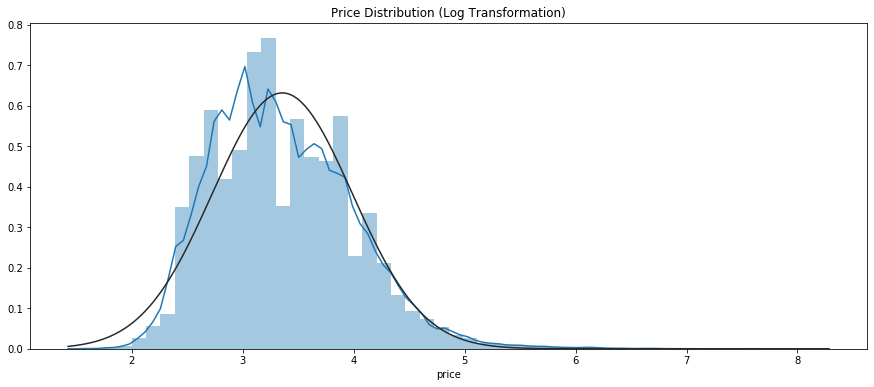

In [15]:
# log transformation
log['price'] = np.log1p(log['price'])

plt.figure(figsize=(15,6))
plt.title("Price Distribution (Log Transformation)")
ax = sns.distplot(log['price'], fit=norm)

We finally decide to chooes option of dropping tails. Since this way allows us to better explain the variables

In [16]:
df = df[df['price']<100]

### Categorical features

- Country (object)
- Description (object)
- Designation (object)	
- Province (object)	
- Region_1 (object)	
- Region_2 (object)	
- Taster_name (object)	
- Taster_twitter_handle (object)	
- Title (object)	
- Variety (object)	
- Winery (object)

#### Clarification
---
By looking at the missing value rate for each column in the chart above, we can see that the columns with relatively high missing value rate are region_2(61%), region_1(16%), taster_name(20%), designation(28%), and twitter_handle(24%).

- Region_2: According to the dataset description in Kaggle, sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank. It's reasonable that region_2 has empty value since that record doesn't have a more specific region specified within that wine growing area.

- Taster_name: It's reasonable that some of the wines are not being tasted by a wine taster, so the value in that record might be blank.

- Taster_twitter_handle: It's reasonable that the taster of that wine doesn't have a Twitter account or that wine even not being tasted by a wine taster, so the value in that record might be blank.

- Region_1: We want to find out the relationship between country and wine's price or point, so we think the missing value of region_1 will not have a significant influence on our analysis and prediction.

- Designation: The designation is the vineyard within the winery where the grapes that made the wine are from, same as the feature above, we think designation will not have a significant influence on our analysis and prediction, so we'll just leave these missing value there.




##### But let's still take a look at the count of unique categories for each of our categorical features :)

In [17]:
numerical_features = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

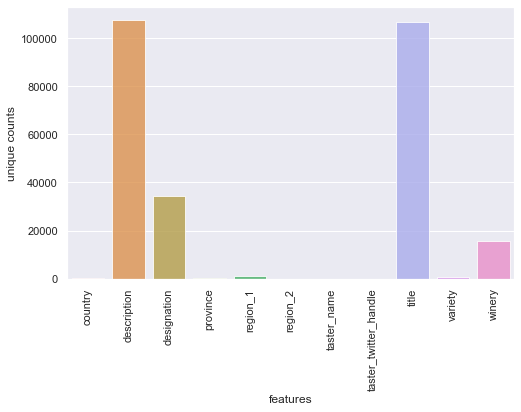

In [18]:
categorical_features_count = df.select_dtypes(exclude=numerical_features).nunique()
sns.set(rc={'figure.figsize':(8,5)})
categorical_features_count_plot = sns.barplot(categorical_features_count.index,\
                                            categorical_features_count.values, alpha=0.8)
categorical_features_count_plot.set(xlabel = 'features', ylabel = 'unique counts')
for item in categorical_features_count_plot.get_xticklabels():
    item.set_rotation(90)

Except for the columns we clarified above, we found that description and title are the most miscellaneous and we will further process these two columns later.

### Country

Here we will check the country names are all unique without typo.

In [19]:
df['country'].unique()

array(['Portugal', 'US', 'Spain', 'Italy', 'France', 'Germany',
       'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa',
       'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico',
       'Canada', nan, 'Turkey', 'Czech Republic', 'Slovenia',
       'Luxembourg', 'Croatia', 'Georgia', 'Uruguay', 'England',
       'Lebanon', 'Serbia', 'Brazil', 'Moldova', 'Morocco', 'Peru',
       'India', 'Bulgaria', 'Cyprus', 'Armenia', 'Switzerland',
       'Bosnia and Herzegovina', 'Ukraine', 'Slovakia', 'Macedonia',
       'China'], dtype=object)

There is no need to process contry column. We are curious about which country has most wine and the following figure shows the distrubution and the table shows the top 5 countries.

In [20]:
country = pd.DataFrame({'country': df["country"].value_counts().index, 'count': df["country"].value_counts().values})
country.head(5)

,country,count
0,US,52949
1,France,16674
2,Italy,16143
3,Spain,6348
4,Portugal,4779


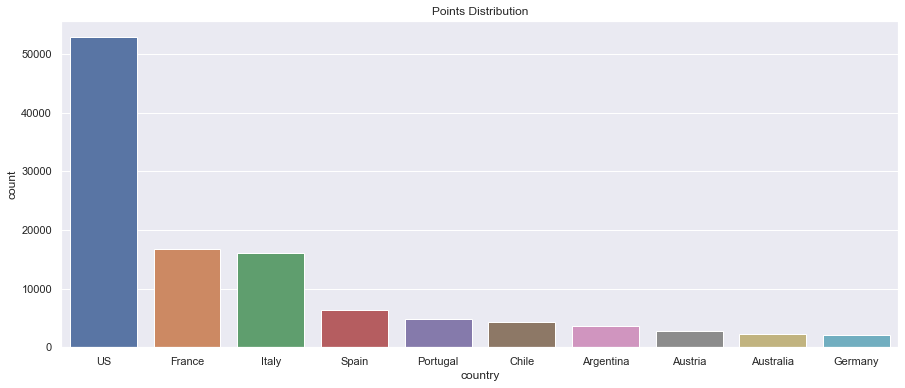

In [21]:
plt.figure(figsize = (15,6))
plt.title('Points Distribution')
sns.barplot(x= 'country', y= 'count', data=country.head(10))
locs, labels = plt.xticks()
plt.show()

Base on the use cases, there are three needed columns should be processed which are 'Description', 'Title' and 'Variety'. We would first take a look at the the "Description" and the "Title" columns. Since these two columns are text data, we will apply regular expression to clean the text data and try to use some natural language processing(NLP) techniques to find out some interesting insights.

In [22]:
df[df.duplicated(['description','title'])].shape[0]

9216

We found that there are a lot of duplicates in the description and title, so we want to get rid of those duplicated records.

In [23]:
df = df.drop_duplicates(['description','title'])
df = df.reset_index(drop=True)

In [24]:
df.shape

(107808, 13)

In [25]:
# Function to clean text
def clean_text(raw_text):
    # convert to string if not in string form
    str_text = raw_text.apply(lambda x: str(x))

    # convert to lower case
    lower_text = str_text.apply(lambda x: x.lower())

    # remove '@'mention - handler
    no_handler_text = lower_text.apply(lambda x: re.sub(r'@\S+', '', x))

    # remove URL Links
    no_handler_URL_text = no_handler_text.apply(lambda x: re.sub('https?://[A-Za-z0-9./]+', '', x))

    # remove html codes
    no_handler_URL_html_text = no_handler_URL_text.apply(lambda x: re.sub('&[A-Za-z]+;','',x))

    # remove emojis
    no_handler_URL_html_emoji_text = no_handler_URL_html_text.apply(lambda x: demoji.replace(x,""))

    # remove punctuations
    no_punc_text = no_handler_URL_html_emoji_text.apply(lambda x: re.sub(r"""
               [),.;:@#?!&$('`’/"-]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               x, flags=re.VERBOSE))
    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_text = no_punc_text.apply(lambda x: x.split())
    cleaned_text = cleaned_text.apply(lambda x: [w for w in x if w not in stopword_set])
    cleaned_text = cleaned_text.apply(lambda x: " ".join(x))

    return cleaned_text

### Description

Clean text for "Description" column

In [26]:
df['description'] = clean_text(df['description'])

In [27]:
df['description']

0         ripe fruity wine smooth still structured firm ...
1         tart snappy flavors lime flesh rind dominate g...
2         pineapple rind lemon pith orange blossom start...
3         much like regular bottling 2012 comes across r...
4         blackberry raspberry aromas show typical navar...
                                ...                        
107803    notes honeysuckle cantaloupe sweeten delicious...
107804    citation given much decade bottle age prior re...
107805    well drained gravel soil gives wine crisp dry ...
107806    dry style pinot gris crisp acidity also weight...
107807    big rich dry powered intense spiciness rounded...
Name: description, Length: 107808, dtype: object

We would like to discover what is the most common words used for wine description, so we use regex to tokenize sentences to list of words for further analysis.

In [28]:
tokenizer = RegexpTokenizer(r'\w+')
description_token = df['description'].apply(tokenizer.tokenize)
description_token.head(10)

0    [ripe, fruity, wine, smooth, still, structured...
1    [tart, snappy, flavors, lime, flesh, rind, dom...
2    [pineapple, rind, lemon, pith, orange, blossom...
3    [much, like, regular, bottling, 2012, comes, a...
4    [blackberry, raspberry, aromas, show, typical,...
5    [bright, informal, red, opens, aromas, candied...
6    [dry, restrained, wine, offers, spice, profusi...
7    [savory, dried, thyme, notes, accent, sunnier,...
8    [great, depth, flavor, fresh, apple, pear, fru...
9    [soft, supple, plum, envelopes, oaky, structur...
Name: description, dtype: object

In [29]:
all_words = [word for tokens in description_token for word in tokens]
vocab = sorted(list(set(all_words)))

Let's take a look at the top 100 most common words used for wine description.

In [30]:
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('wine', 63423),
 ('flavors', 54176),
 ('fruit', 41135),
 ('aromas', 33270),
 ('palate', 32555),
 ('finish', 30090),
 ('acidity', 27970),
 ('cherry', 24586),
 ('tannins', 24234),
 ('drink', 24172),
 ('black', 23449),
 ('ripe', 21526),
 ('red', 17981),
 ('notes', 16101),
 ('spice', 15534),
 ('oak', 15197),
 ('dry', 14691),
 ('nose', 14659),
 ('fresh', 14263),
 ('berry', 13996),
 ('rich', 13872),
 ('full', 13009),
 ('plum', 12610),
 ('apple', 11516),
 ('sweet', 11420),
 ('blend', 11234),
 ('soft', 11188),
 ('well', 10820),
 ('white', 10803),
 ('light', 10734),
 ('blackberry', 10663),
 ('crisp', 10557),
 ('offers', 10308),
 ('fruits', 10277),
 ('texture', 9990),
 ('citrus', 9983),
 ('dark', 9882),
 ('bodied', 9790),
 ('vanilla', 9495),
 ('shows', 9488),
 ('cabernet', 8949),
 ('bright', 8858),
 ('pepper', 8658),
 ('green', 8388),
 ('good', 8264),
 ('raspberry', 8231),
 ('lemon', 8200),
 ('juicy', 7864),
 ('fruity', 7671),
 ('peach', 7432),
 ('like', 7166),
 ('chocolate', 7163),
 ('touch',

### Title

Clean text for "Title" column

In [31]:
df.shape

(107808, 13)

In [32]:
df['title'] = clean_text(df['title'])

In [33]:
df['title']

0               quinta dos avidagos 2011 avidagos red douro
1               rainstorm 2013 pinot gris willamette valley
2         st julian 2013 reserve late harvest riesling l...
3         sweet cheeks 2012 vintner reserve wild child b...
4          tandem 2011 ars vitro tempranillo merlot navarra
                                ...                        
107803    dr h thanisch erben müller burggraef 2013 brau...
107804                      citation 2004 pinot noir oregon
107805     domaine gresser 2013 kritt gewurztraminer alsace
107806          domaine marcel deiss 2012 pinot gris alsace
107807    domaine schoffit 2012 lieu dit harth cuvée car...
Name: title, Length: 107808, dtype: object

### Variety

After cleaning text data for "Description" and "Title" columns, we would like to look at the "Variety" column to see if there's any duplicated value in it.

In [34]:
df['variety'].head(10)

0        Portuguese Red
1            Pinot Gris
2              Riesling
3            Pinot Noir
4    Tempranillo-Merlot
5              Frappato
6        Gewürztraminer
7        Gewürztraminer
8            Pinot Gris
9    Cabernet Sauvignon
Name: variety, dtype: object

We'd like to observe length of variety.

In [35]:
df['variety'] = clean_text(df['variety'])
variety = df['variety']
df['variety_count'] = df['variety'].str.split().str.len()
df['variety_count'].value_counts()

1    49933
2    49174
4     6919
3     1779
5        2
0        1
Name: variety_count, dtype: int64

We found that there are some differences between variety, but they are actually the same word. Hence the following process is to find the similarity words for correcting. We analyze words with different word counts.

In [36]:
variety_1 = df[(df['variety_count'] == 1)]
variety_2 = df[(df['variety_count'] == 2)]
variety_3 = df[(df['variety_count'] == 3)]
variety_4 = df[(df['variety_count'] == 4)]
variety_1_tfidf = variety_1["variety"]
variety_2_tfidf = variety_2["variety"]
variety_3_tfidf = variety_3["variety"]
variety_4_tfidf = variety_4["variety"]
variety_1 = variety_1.reset_index(drop=True)
variety_2 = variety_2.reset_index(drop=True)
variety_3 = variety_3.reset_index(drop=True)
variety_4 = variety_4.reset_index(drop=True)

In [37]:
df[(df['variety_count'] == 5)]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,variety_count
837,US,earthy nutty aroma flavor come intense sweetne...,Vin Doux Naturel,87,20.0,California,Shenandoah Valley (CA),Sierra Foothills,Jim Gordon,@gordone_cellars,terre rouge 2013 vin doux naturel muscat blanc...,muscat blanc à petits grains,Terre Rouge,5
14971,France,lush ripe touch heady rich selection brimming ...,Resplandy,87,12.0,Languedoc-Roussillon,Muscat de Saint-Jean de Minervois,NaN,Lauren Buzzeo,@laurbuzz,les vignerons de la méditerranée nv resplandy ...,muscat blanc à petits grains,Les Vignerons de la Méditerranée,5


In [38]:
variety_1_tfidf = variety_1_tfidf.reset_index(drop=True)
variety_2_tfidf = variety_2_tfidf.reset_index(drop=True)
variety_3_tfidf = variety_3_tfidf.reset_index(drop=True)
variety_4_tfidf = variety_4_tfidf.reset_index(drop=True)
ngram_range = (1, 1)
vectorizer = TfidfVectorizer("char", ngram_range=ngram_range, sublinear_tf=True)
tfidf_matrix_1 = vectorizer.fit_transform(variety_1_tfidf.astype('U'))
tfidf_matrix_2 = vectorizer.fit_transform(variety_2_tfidf.astype('U'))
tfidf_matrix_3 = vectorizer.fit_transform(variety_3_tfidf.astype('U'))
tfidf_matrix_4 = vectorizer.fit_transform(variety_4_tfidf.astype('U'))

We used TF-IDF + N-gram to generate a sparse matrix that each row is the document (variety), each column is a n-gram (from 1 to 2). And the
TF-IDF score is computed for each n-gram in each document.

By using the sparse_dot_topn library, we can find out the top 10 most similar varieties for each variety in the dataset.

The result of duplicate detection model has the top 10 most similar varieties for each variety, we can leverage the results to identify the duplicated records

In [39]:
def awesome_sparse_dot_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape

    idx_dtype = np.int32

    nnz_max = M * ntop
    indptr = np.zeros(M + 1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    # if A or B are all zeros matrix, return all zero matrix directly
    if len(A.indices) > 0 and len(A.data) > 0 and len(A.indptr) > 0 and \
            len(B.indices) > 0 and len(B.data) > 0 and len(B.indptr) > 0:
        ct.sparse_dot_topn(
            M, N, np.asarray(A.indptr, dtype=idx_dtype),
            np.asarray(A.indices, dtype=idx_dtype),
            A.data,
            np.asarray(B.indptr, dtype=idx_dtype),
            np.asarray(B.indices, dtype=idx_dtype),
            B.data,
            ntop,
            lower_bound,
            indptr, indices, data)

    # N.B. since the indices are grid id here, we still keep the shape as (M,N)
    return csr_matrix((data, indices, indptr), shape=(M, N))

In [40]:
matches = awesome_sparse_dot_top(tfidf_matrix_2, tfidf_matrix_2.transpose(), 10)

In [41]:
def get_matches_df(sparse_matrix, name_vector, top=matches.count_nonzero()):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    left_side_idx = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    right_side_idx = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        left_side_idx[index] = sparserows[index]
        right_side[index] = name_vector[sparsecols[index]]
        right_side_idx[index] = sparsecols[index]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                         'left_side_idx': left_side_idx,
                         'right_side': right_side,
                         'right_side_idx': right_side_idx,
                         'similarity': similairity})

In [42]:
matches_df = get_matches_df(matches, variety_2_tfidf)

In [43]:
matches_df

,left_side,left_side_idx,right_side,right_side_idx,similarity
0,portuguese red,0,portuguese red,48780,1.0
1,portuguese red,0,portuguese red,48829,1.0
2,portuguese red,0,portuguese red,48830,1.0
3,portuguese red,0,portuguese red,48843,1.0
4,portuguese red,0,portuguese red,48879,1.0
...,...,...,...,...,...
491379,pinot gris,49173,pinot gris,49144,1.0
491380,pinot gris,49173,pinot gris,49165,1.0
491381,pinot gris,49173,pinot gris,49167,1.0
491382,pinot gris,49173,pinot gris,49171,1.0


In [44]:
unique_df = matches_df[(matches_df['similarity'] < 0.99999)].sort_values(["left_side_idx", "similarity"], ascending=(True, False))

In [45]:
unique_df

,left_side,left_side_idx,right_side,right_side_idx,similarity
37,tempranillo merlot,3,cabernet merlot,38348,0.729363
38,tempranillo merlot,3,merlot cabernet,41149,0.729363
39,tempranillo merlot,3,cabernet merlot,42211,0.729363
2795,garnacha tintorera,279,garnacha blend,24723,0.572154
2798,garnacha tintorera,279,garnacha blend,38606,0.572154
...,...,...,...,...,...
490551,pinot chardonnay,49090,chardonnay sauvignon,37905,0.909031
490959,touriga franca,49131,touriga nacional,46276,0.397497
490960,touriga franca,49131,touriga nacional,46781,0.397497
490961,touriga franca,49131,touriga nacional,47816,0.397497


In [46]:
#variety_1.to_csv("variety_1")
#variety_2.to_csv("variety_2")
#variety_3.to_csv("variety_3")
#variety_4.to_csv("variety_4")

Base on the analysis above, we found that some variety are the same but in different words order. For example, the table below shows that there are two different term "cabernet sauvignon cabernet franc" and "cabernet franc cabernet sauvignon" which are the same. We then correct this kind of situation.

In [47]:
variety_4['variety'].value_counts()

bordeaux style red blend               4595
rhône style red blend                  1254
bordeaux style white blend              610
rhône style white blend                 380
touriga nacional cabernet sauvignon      25
cabernet sauvignon cabernet franc        20
cabernet franc cabernet sauvignon        15
chenin blanc sauvignon blanc              6
loin de l oeil                            6
sauvignon blanc chenin blanc              4
cabernet sauvignon merlot shiraz          2
pinot grigio sauvignon blanc              1
pinot blanc pinot noir                    1
Name: variety, dtype: int64

In [48]:
df['variety'] = df['variety'].apply(lambda x: ' '.join(sorted(x.split())))

## Data Analysis (Use Cases)
---
- Top 5 countries and regions with the best wine quality.
- Relationship between wine quality and price, description and title.
- Top 5 wine type and countries with highest price–performance ratio.

First, we select the fields we will use in the use cases and show the first 5 rows to check the dataframe.

In [49]:
df_used = df[['country', 'description', 'points', 'price', 'title', 'variety']]
df_used.head(5)

,country,description,points,price,title,variety
0,Portugal,ripe fruity wine smooth still structured firm ...,87,15.0,quinta dos avidagos 2011 avidagos red douro,portuguese red
1,US,tart snappy flavors lime flesh rind dominate g...,87,14.0,rainstorm 2013 pinot gris willamette valley,gris pinot
2,US,pineapple rind lemon pith orange blossom start...,87,13.0,st julian 2013 reserve late harvest riesling l...,riesling
3,US,much like regular bottling 2012 comes across r...,87,65.0,sweet cheeks 2012 vintner reserve wild child b...,noir pinot
4,Spain,blackberry raspberry aromas show typical navar...,87,15.0,tandem 2011 ars vitro tempranillo merlot navarra,merlot tempranillo


### Top 5 countries and regions with the best wine quality.

For this purpose, we will calculate the mean points of wine for each countries. Ane then list the top 5 countries with highest mean of points which represent high wine quality.

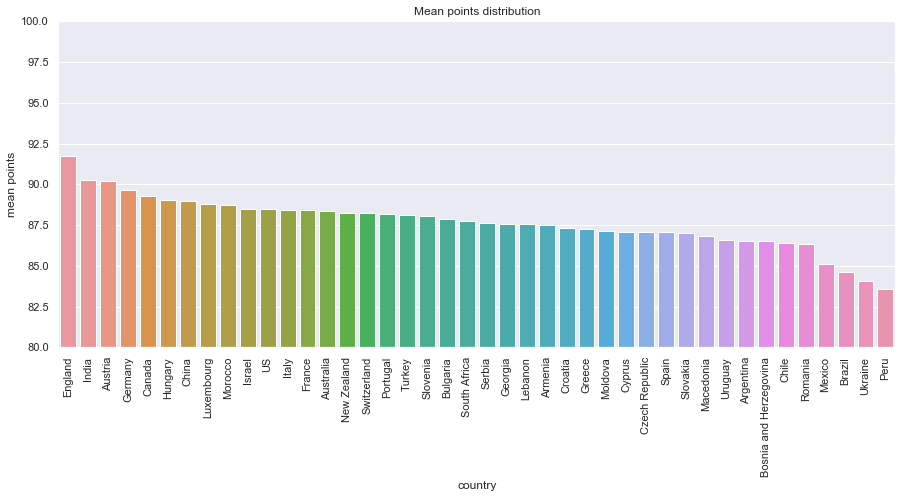

In [50]:
df_country_wine_qual = df.groupby(['country'], as_index = False)['points'].mean()
df_country_wine_qual.columns = ['country', 'mean points']

plt.figure(figsize = (15,6))
plt.title('Mean points distribution')
sns.barplot(x= 'country', y= 'mean points', data=df_country_wine_qual.sort_values(by=['mean points'], ascending=False))
plt.ylim(80, 100)
locs, labels = plt.xticks()
plt.xticks(rotation=90)
plt.show()

We can see that the top 5 countries are England, India, Austria, Germany, and Canada with respective wine points shown down below.

In [51]:
df_country_wine_qual.sort_values(by=['mean points'], ascending=False).head(5)

,country,mean points
13,England,91.762712
19,India,90.250000
3,Austria,90.183121
16,Germany,89.674457
7,Canada,89.304933


## Relationship between wine quality and price, description and title.

Here, we would like to see the relationship between wine quality and three variables that we think are related to the points.

#### 1. Price

We use the regression plot to see the relationship and then calculate the correlation between variables.

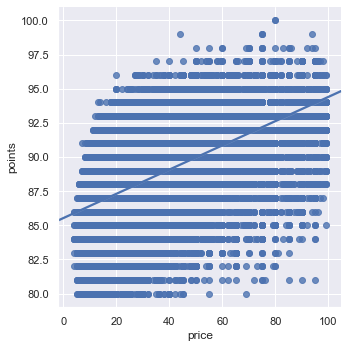

In [52]:
sns.lmplot('price', 'points', data = df)

In [53]:
print('Correlation between wine points and price: '+ str(round(np.corrcoef(df['price'], df['points'])[1,0], 2)))

Correlation between wine points and price: 0.55


The positive relationship between price and points is obvious. The correlation reach about 0.55.

#### 2. Relationship with Description and Title

We are curious about whether the more descriptions, the better the wine evaluation.

In [54]:
df['description_len'] = df['description'].apply(lambda x: len(x))
print('Correlation between wine points and length of description: '+ str(round(np.corrcoef(df['description_len'], df['points'])[1,0], 2)))

Correlation between wine points and length of description: 0.58


In [55]:
df['title_len'] = df['title'].apply(lambda x: len(x))
print('Correlation between wine points and length of title: '+ str(round(np.corrcoef(df['title_len'], df['points'])[1,0], 2)))

Correlation between wine points and length of title: 0.14


By calculating the correlation between points and length of descrition and title, we found that the wine quality is related to the length of description but not related to length of title. Hence, we conclude that the more descriptions, the better the evaluation of the wine.

## Top 5 wine type and countries with highest price–performance ratio.

Here we will focus on the data with price lower than 100 to find the price-performance ratio. Base on the data, we fit a regression line and predict the price by the regression coefficients. We defind that the high price-performance ratio wines are the wines that have higher points than the predict points.

We will then calculate the mean of difference between points and predict points to see which wine type and countries wines have higher points than the predict points.

In [56]:
from sklearn import linear_model
x=np.array(df[df['price']<100]['price']).reshape(df[df['price']<100].shape[0], -1)
y=np.array(df[df['price']<100]['points']).reshape(df[df['price']<100].shape[0], -1)
model=linear_model.LinearRegression()
model.fit(x,y)
high_price_performance_df=df.copy()
high_price_performance_df['points_fit']=model.coef_[0]*high_price_performance_df['price']+model.intercept_
high_price_performance_df=high_price_performance_df[high_price_performance_df['points']>high_price_performance_df['points_fit']].reset_index(drop=True)
high_price_performance_df['points_diff'] = high_price_performance_df['points']-high_price_performance_df['points_fit']

The following table list top 5 wine type with highest price-performance values wines.

In [57]:
high_price_performance_df.groupby(['variety'], as_index = False)['points_diff'].mean().sort_values(by=['points_diff'], ascending=False).head(5)

,variety,points_diff
228,gelber traminer,6.364012
77,blauburgunder,5.782653
284,kotsifali,5.314643
181,del pais tinta,5.255698
259,gris trousseau,5.161997


The following table list top 5 countries with highest price-performance values wines.

In [58]:
high_price_performance_df.groupby(['country'], as_index = False)['points_diff'].mean().sort_values(by=['points_diff'], ascending=False).head(5)

,country,points_diff
19,India,3.498144
3,Austria,2.642539
13,England,2.325428
7,Canada,2.216681
29,Portugal,2.176472
